In [12]:
import os
from itertools import product
import json

import numpy as np
import matplotlib.pyplot as plt

from visualization.utils import gradient_line

Missing experiment metrics file metrics/ambar-bpr/c1.0__unfrozen_itememb__selection_relevance__k25__lr0.0001.json! Skipping...
Missing experiment metrics file metrics/ambar-bpr/c1.0__unfrozen_itememb__selection_relevance__k50__lr0.0005.json! Skipping...
Missing experiment metrics file metrics/ambar-bpr/c1.0__unfrozen_itememb__selection_relevance__k50__lr0.0001.json! Skipping...


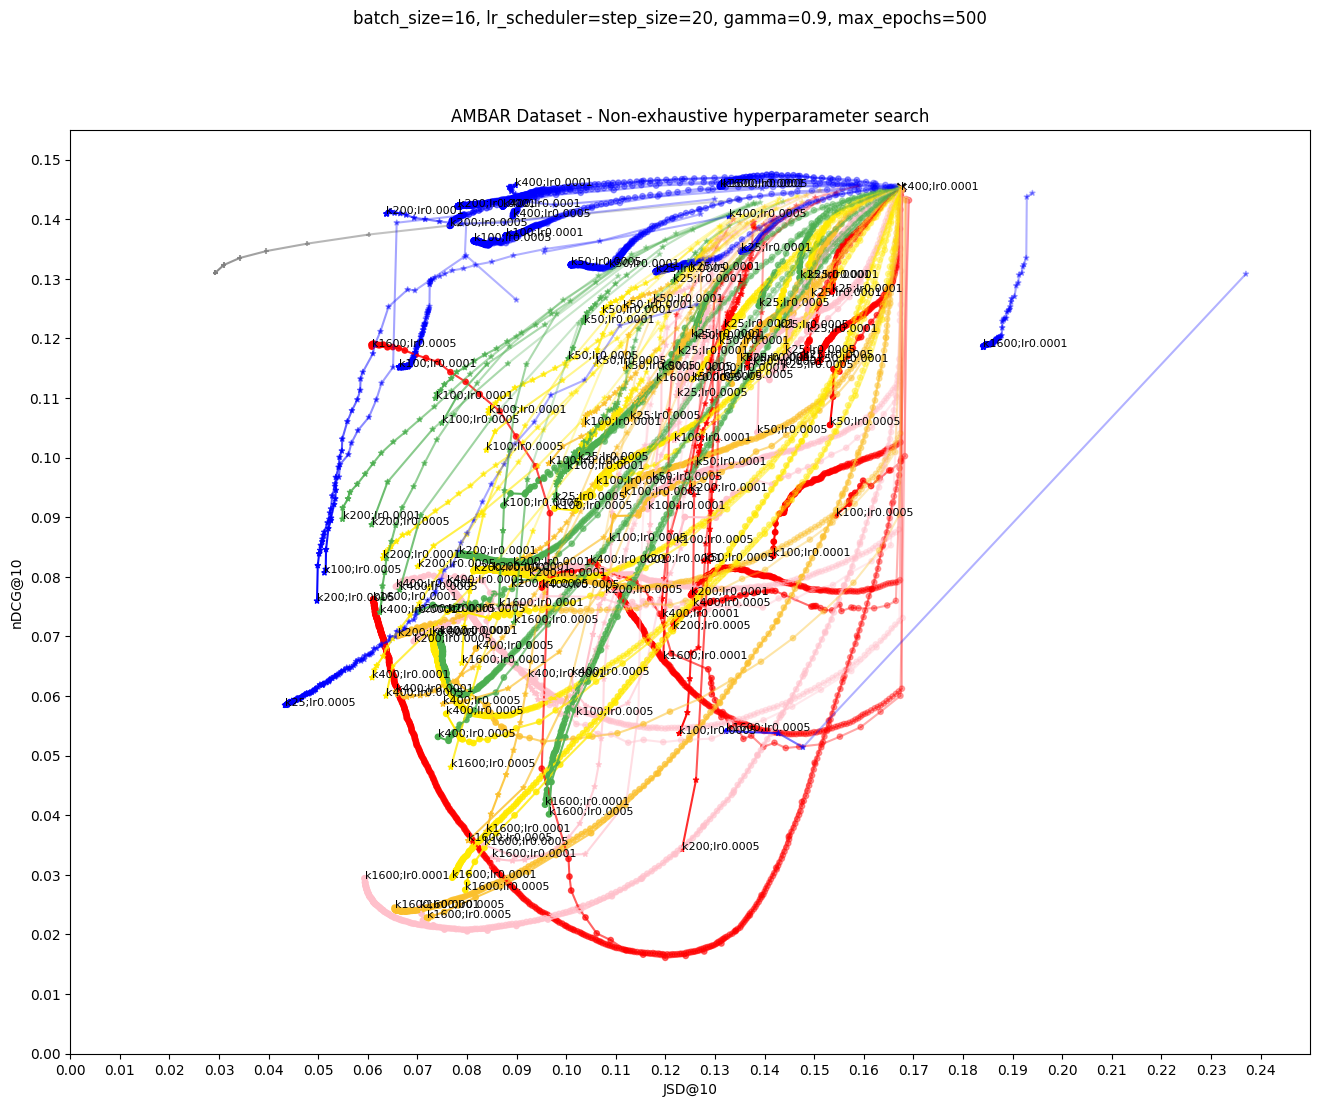

In [14]:
"""AMBAR Dataset"""
batch_size = 16
dataset = 'AMBAR Dataset'
lr_scheduler = 'step_size=20, gamma=0.9'

title = f'{dataset} - Non-exhaustive hyperparameter search'
suptitle = f'batch_size={batch_size}, lr_scheduler={lr_scheduler}, max_epochs=500'

COMBINED_MODE_ALPHA = [
    0.0,
    0.1,
    0.25,
    0.5,
    0.75,
    # 0.9,
    1.0
]
FROZEN_ITEM_EMB = [
    True,
    False
]
CANDIDATE_SELECTION_STRATEGIES = [
    'relevance',
    # 'random'
]
K_CANDIDATES = [
    25,
    50,
    100,
    200,
    400,
    1600,
]
LEARNING_RATE = [
    0.0005,
    0.0001,
    # 0.00001,
]

pop_dict = dict()
for parameters in product(
        COMBINED_MODE_ALPHA,
        FROZEN_ITEM_EMB,
        CANDIDATE_SELECTION_STRATEGIES,
        K_CANDIDATES,
        LEARNING_RATE
):
    combined_mode_alpha, frozen_item_emb, candidate_selection_strategy, k_candidates, learning_rate = parameters
    frozen_str = "frozen_itememb" if frozen_item_emb else "unfrozen_itememb"
    experiment_name = f'c{combined_mode_alpha}__{frozen_str}__selection_{candidate_selection_strategy}__k{k_candidates}__lr{learning_rate}'

    file = os.path.join('metrics', 'ambar-bpr', f'{experiment_name}.json')

    if not os.path.exists(file):
        print(f"Missing experiment metrics file {file}! Skipping...")
        continue
    with open(file) as f:
        d = json.load(f)
        if 'baseline' not in pop_dict.keys():
            pop_dict['baseline'] = d['base_recommendations']
        if 'postprocessed' not in pop_dict.keys():
            if len(d['postprocessed'].keys()) > 0:
                pop_dict['postprocessed'] = {'ndcg': [d['postprocessed'][l]['ndcg'] for l in d['postprocessed'].keys()],
                                             'jsd': [d['postprocessed'][l]['jsd'] for l in d['postprocessed'].keys()]}

        pop_dict[experiment_name] = {'ndcg': [d['finetuned'][l]['ndcg'] for l in d['finetuned'].keys()],
                                     'jsd': [d['finetuned'][l]['jsd'] for l in d['finetuned'].keys()]}

fig, ax = plt.subplots(figsize=(16, 12))
plt.title(title)
plt.suptitle(suptitle)

ax.scatter(pop_dict['baseline']['jsd'], pop_dict['baseline']['ndcg'], marker='x', color='black', label='Base model')

gradient_line(pop_dict['postprocessed']['jsd'], pop_dict['postprocessed']['ndcg'], ax, c='gray', marker='+',
              lbl='Post-processed')

for experiment in pop_dict.keys():
    if experiment == 'baseline' or experiment == 'postprocessed':
        continue

    combined_mode_alpha, frozen_item_emb, candidate_selection_strategy, k_candidates, learning_rate = experiment.split('__')

    color = {
        'c0.0': 'red',
        'c0.1': 'pink',
        'c0.25': '#FBC02D',
        'c0.5': '#ffea00',
        'c0.75': '#4CAF50',
        'c0.9': '#00FFFF',
        'c1.0': 'blue'
    }[combined_mode_alpha]

    color_lr = {
        'lr0.001': 'red',
        'lr0.0005': 'green',
        'lr0.0001': 'blue'
    }[learning_rate]

    marker = {
        ('frozen_itememb', 'selection_relevance'): 'o',
        ('frozen_itememb', 'selection_random'): 'D',
        ('unfrozen_itememb', 'selection_relevance'): '*',
        ('unfrozen_itememb', 'selection_random'): 'X',
    }[frozen_item_emb, candidate_selection_strategy]

    final_label = f'{k_candidates};{learning_rate}'
    gradient_line(pop_dict[experiment]['jsd'], pop_dict[experiment]['ndcg'], ax,
                  lbl=experiment,
                  c=color, marker=marker, final_model_label=final_label, filter=None)

plt.ylabel('nDCG@10')
plt.xlabel('JSD@10')

plt.xlim(0, 0.25)
plt.ylim(0, 0.155)

start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.round(np.arange(start, end, 0.01), 2))

start, end = ax.get_ylim()

ax.yaxis.set_ticks(np.round(np.arange(start, end, 0.01), 2))

# plt.legend()
plt.show()